Let's begin by loading our three main libraries: pandas, plotnine, and sqlite3:

In [0]:
import pandas as pd
import plotnine as p9
import sqlite3

Let's go ahead and mount the google drive to get easy-access to the course data:

In [2]:
#mount google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Let's create a database.

In [0]:
conn = sqlite3.connect('exercises.db')

Now populate the database with data from MIMIC and the Verana Health challenge:

In [0]:
for filename, table in [
          ("mimic_iii/PATIENTS.csv", "patients"),
          ("mimic_iii/DIAGNOSES_ICD.csv", "diagnoses"),
          ("mimic_iii/D_ICD_DIAGNOSES.csv", "d_diagnoses"),
          ("verana_health/patient_clinical.csv", "clinical"),
          ("verana_health/patient_demographics.csv", "demographics"),
          ("verana_health/patient_history.csv", "history")
]:
  data = pd.read_csv(f'/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/{filename}')
  data.to_sql(table, conn, if_exists='replace', index=False)

## Exercise 1
Do a SQL query using `pd.read_sql_query` to get all the gender information from the `patients` table and plot it in a bar chart:

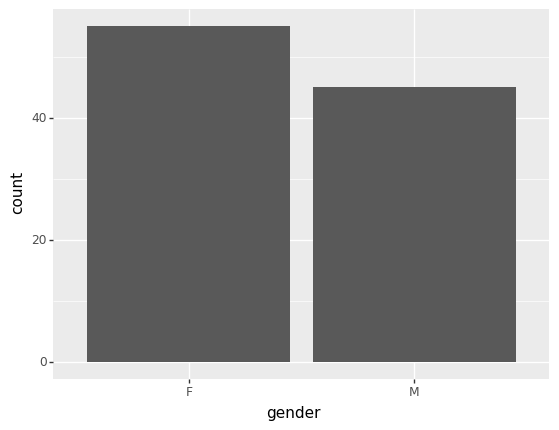

<ggplot: (-9223363250429072012)>

In [5]:
p9.ggplot(pd.read_sql_query('SELECT gender FROM patients', conn), p9.aes(x='gender')) + p9.geom_bar()

If all went well, you should have reproduced a figure from Monday. Let's select `gender` and `icd9_code` information from the combination of the `patients` and `diagnoses` tables where their `subject_id`s coincides:

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, icd9_code
  FROM patients, diagnoses
  WHERE patients.subject_id == diagnoses.subject_id
''', conn)

Your data frame should have 1761 rows and 2 columns.

Now plot just the `icd9_code` information in a bar graph:

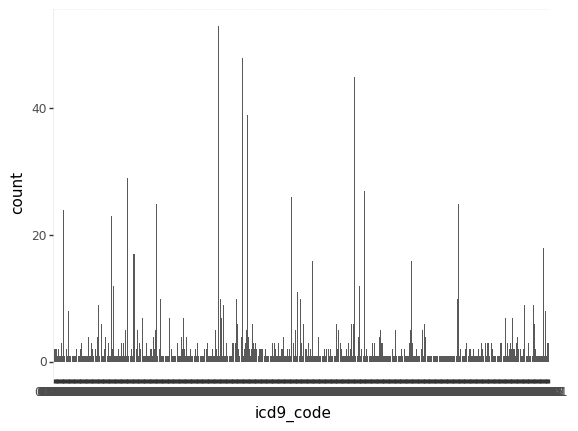

<ggplot: (-9223363250479096439)>

In [7]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code')) + p9.geom_bar()

Whoa, that's way too many codes. Use `.value_counts()` to find out how many distinct `icd9_code` values there are.

In [8]:
diagnoses_by_gender['icd9_code'].value_counts()

4019     53
42731    48
5849     45
4280     39
25000    31
         ..
2555      1
E8809     1
03843     1
33385     1
V5419     1
Name: icd9_code, Length: 581, dtype: int64

Compare the `.value_counts()` to 10 and `sum` the result to find the number of diagnoses that appeared more than 10 times. Repeat for more than 20.

In [9]:
sum(diagnoses_by_gender['icd9_code'].value_counts() > 10)

28

In [10]:
sum(diagnoses_by_gender['icd9_code'].value_counts() > 20)

13

Add this additional condition to your `WHERE` clause with an `AND` to  extract the data only for diagnoses given more than 20 times:
```
icd9_code IN (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
  ```

This SELECT inside the parentheses is constructing a one column table listing only those icd9_codes that appear more than 20 times.

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, icd9_code
  FROM patients, diagnoses
  WHERE patients.subject_id == diagnoses.subject_id AND icd9_code IN (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
''', conn)

Using this smaller dataset, make a bar chart comparing the frequencies of various `icd9_code`s:

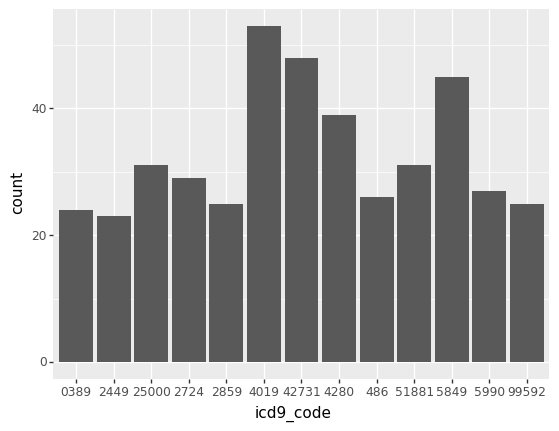

<ggplot: (-9223363250483702412)>

In [12]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code')) + p9.geom_bar()

Apply a `fill` aesthetic argument, based on the `gender`:



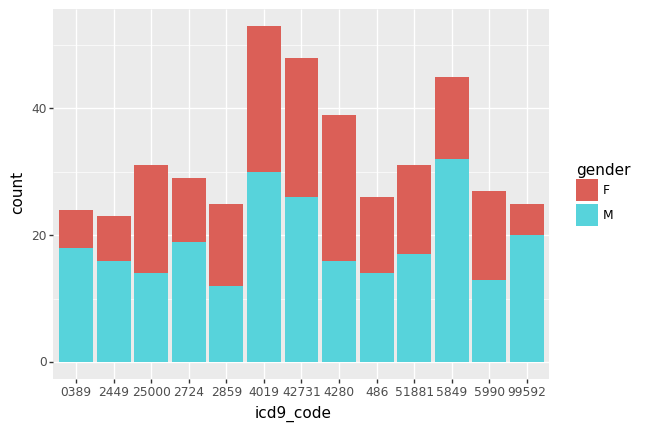

<ggplot: (-9223363250483853813)>

In [13]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code', fill='gender')) + p9.geom_bar()

It's clear that `icd9_code` 99592 is assigned to males more than to females, but what about `icd9_code` 2859? It's hard to tell with stacked bar-charts. Recall that we can make the colors appear side-by-side using a `position='dodge'` parameter to `p9.geom_bar()`. Do that:

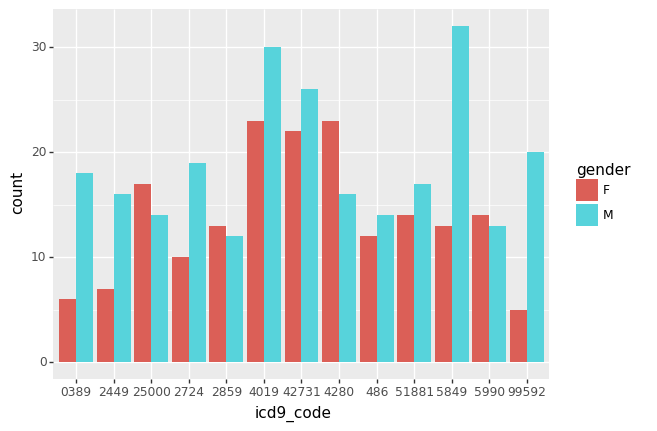

<ggplot: (8786371073491)>

In [14]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code', fill='gender')) + p9.geom_bar(position='dodge')

We now see clearly that more females got diagnosis code 2859 than males. What do these codes mean though? To find out, redo your SQL query again, this time also pulling in the `short_title` field from `d_diagnoses` where `d_diagnoses.icd9_code == diagnoses.icd9_code`.

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, diagnoses.icd9_code, short_title
  FROM patients, diagnoses, d_diagnoses
  WHERE patients.subject_id == diagnoses.subject_id AND d_diagnoses.icd9_code == diagnoses.icd9_code and diagnoses.icd9_code in (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
''', conn)

Check the query results to make sure that it looks like what you expect. Strictly speaking, you don't need to have `icd9_code` in your table, but I kept it in, giving me three columns and 426 rows.

In [16]:
diagnoses_by_gender

,gender,icd9_code,short_title
0,F,42731,Atrial fibrillation
1,F,4280,CHF NOS
2,F,25000,DMII wo cmp nt st uncntr
3,F,0389,Septicemia NOS
4,F,486,"Pneumonia, organism NOS"
...,...,...,...
421,M,2724,Hyperlipidemia NEC/NOS
422,F,486,"Pneumonia, organism NOS"
423,F,99592,Severe sepsis
424,F,2449,Hypothyroidism NOS


Now plot it, putting the `short_title` on the x-axis.

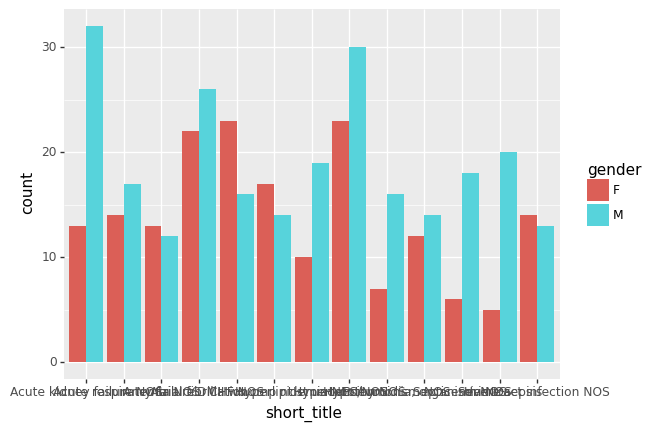

<ggplot: (8786370828359)>

In [17]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='short_title', fill='gender')) + p9.geom_bar(position='dodge')

Remember that adding `p9.theme(axis_text_x=p9.element_text(angle=90))` will rotate the x-axis labels by 90 degrees, making things easier to read. Do that:

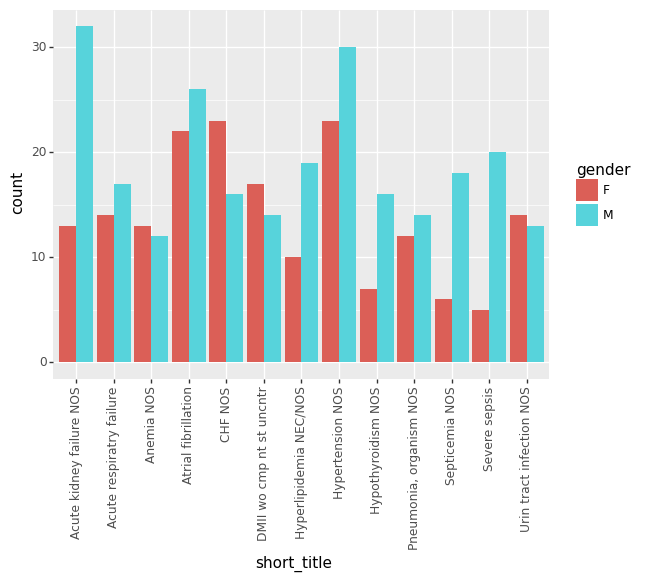

<ggplot: (8786370828485)>

In [18]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='short_title', fill='gender'))+ p9.geom_bar(position='dodge') + p9.theme(axis_text_x=p9.element_text(angle=90))

Visually, you can now quickly find the names of the four common diagnosis codes that are assigned to females more than to males.

## Exercise 2

Get a data frame with the `patient_id`, `sysBP`, `diaBP`, `glucose`, `male`, `currentSmoker`, `cigsPerDay`, `diabetes`, and `BPMeds` columns from combining the `clinical`, `demographics`, and `history` tables where the three are aligned by matching `patient_id` values. (No `patient_id` appears more than once in any of these three tables.)

In [0]:
combined = pd.read_sql_query('''
  SELECT clinical.patient_id, sysBP, diaBP, glucose, male, cigsPerDay, currentSmoker, diabetes, BPMeds
  FROM clinical, demographics, history
  WHERE clinical.patient_id == demographics.patient_id AND demographics.patient_id == history.patient_id
''', conn)

`male`, `currentSmoker`, `diabetes`, and `BPMeds` are coded as `0` for False and `1` for True. That is, a value of `0` in the `currentSmoker` column indicates a non-smoker, whereas a value of `1` in the `currentSmoker` column indicates a smoker. Using the `replace` method of a Pandas series, replace the 0s and 1s with human-readable names. For everything except `male` store the new values in the same column; store gender data in a column called `gender`.

In [0]:
combined['diabetes'] = combined['diabetes'].replace({0: "No diabetes", 1: "Diabetes"})
combined['currentSmoker'] = combined['currentSmoker'].replace({0: "Non-smoker", 1: "Smoker"})
combined['gender'] = combined['male'].replace({0: 'female', 1: 'male'})
combined['BPMeds'] = combined['BPMeds'].replace({0: 'No BPMeds', 1: 'BPMeds'})

Look at your data frame to see if it looks the way you expect:

In [21]:
combined

,patient_id,sysBP,diaBP,glucose,male,cigsPerDay,currentSmoker,diabetes,BPMeds,gender
0,ZKFEHEA2YVD6E5HRJKVWWCU9P,131.0,88.0,61.0,0,0.0,Non-smoker,No diabetes,No BPMeds,female
1,V7NNJV6JVBEW2AGXJ826HQJGM,142.0,94.0,64.0,1,15.0,Smoker,No diabetes,No BPMeds,male
2,K3FVYMBPSVCHDSYJ3XS9GRLJX,124.0,88.0,84.0,0,0.0,Non-smoker,No diabetes,BPMeds,female
3,S5GX8TACV8LZQHJAAR97ZDLD4,114.0,64.0,NaN,0,9.0,Smoker,No diabetes,No BPMeds,female
4,J36F2BMH8ZLFSDC4V48CY7974,140.0,90.0,70.0,0,20.0,Smoker,No diabetes,No BPMeds,female
...,...,...,...,...,...,...,...,...,...,...
4215,WHQQRKWQZWMYPNZJ6AVTP65V2,131.0,72.0,86.0,0,20.0,Smoker,No diabetes,NaN,female
4216,KWGQLTX8PAPKWW9S4LEKVAKJK,126.5,87.0,NaN,0,15.0,Smoker,No diabetes,No BPMeds,female
4217,NW4KMWEQSU99ZEAYK2DMPNBEQ,133.5,83.0,107.0,0,0.0,Non-smoker,No diabetes,No BPMeds,female
4218,J563NFLAS8227VQKM3NDSSSMQ,141.0,98.0,72.0,1,0.0,Non-smoker,No diabetes,No BPMeds,male


We don't need to, but go ahead and drop the `male` column, then check to see if your dataframe changed the way you expected.

In [22]:
combined = combined.drop('male', axis=1)
combined

,patient_id,sysBP,diaBP,glucose,cigsPerDay,currentSmoker,diabetes,BPMeds,gender
0,ZKFEHEA2YVD6E5HRJKVWWCU9P,131.0,88.0,61.0,0.0,Non-smoker,No diabetes,No BPMeds,female
1,V7NNJV6JVBEW2AGXJ826HQJGM,142.0,94.0,64.0,15.0,Smoker,No diabetes,No BPMeds,male
2,K3FVYMBPSVCHDSYJ3XS9GRLJX,124.0,88.0,84.0,0.0,Non-smoker,No diabetes,BPMeds,female
3,S5GX8TACV8LZQHJAAR97ZDLD4,114.0,64.0,NaN,9.0,Smoker,No diabetes,No BPMeds,female
4,J36F2BMH8ZLFSDC4V48CY7974,140.0,90.0,70.0,20.0,Smoker,No diabetes,No BPMeds,female
...,...,...,...,...,...,...,...,...,...
4215,WHQQRKWQZWMYPNZJ6AVTP65V2,131.0,72.0,86.0,20.0,Smoker,No diabetes,NaN,female
4216,KWGQLTX8PAPKWW9S4LEKVAKJK,126.5,87.0,NaN,15.0,Smoker,No diabetes,No BPMeds,female
4217,NW4KMWEQSU99ZEAYK2DMPNBEQ,133.5,83.0,107.0,0.0,Non-smoker,No diabetes,No BPMeds,female
4218,J563NFLAS8227VQKM3NDSSSMQ,141.0,98.0,72.0,0.0,Non-smoker,No diabetes,No BPMeds,male


Make box plots comparing the distributions of number of `cigsPerDay` by `gender`.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 29 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


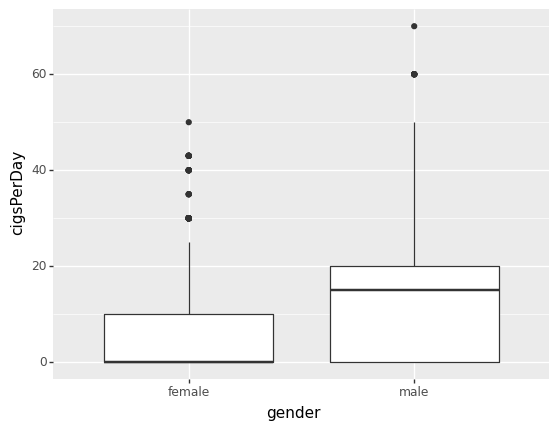

<ggplot: (8786370809159)>

In [23]:
p9.ggplot(combined, p9.aes(y='cigsPerDay', x='gender')) + p9.geom_boxplot()

**INTERPRET YOUR RESULTS**

Using `p9.facet_wrap`, facet this data by whether or not the patient has `diabetes`.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 29 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


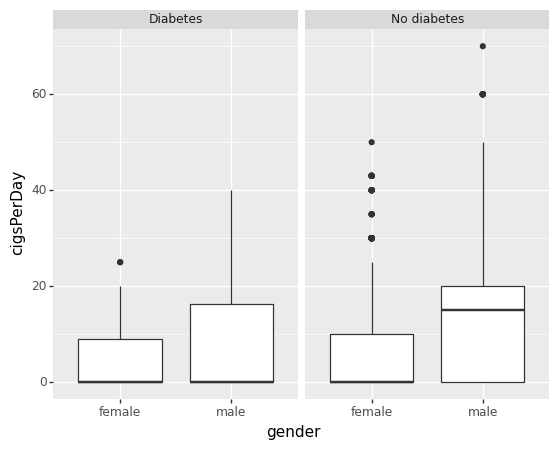

<ggplot: (-9223363250483966681)>

In [24]:
p9.ggplot(combined, p9.aes(y='cigsPerDay', x='gender')) + p9.geom_boxplot() + p9.facet_wrap('diabetes') 

**INTERPRET THIS GRAPH** How does a diagnosis of diabetes affect the likelihood a male smokes? A female? How does it affect the number of cigarettes per day?

By specifying aesthetic maps for `x`, `y`, and `fill` create a box plot figure without faceting that compares the `sysBP` for different `gender` and `BPMeds` states.

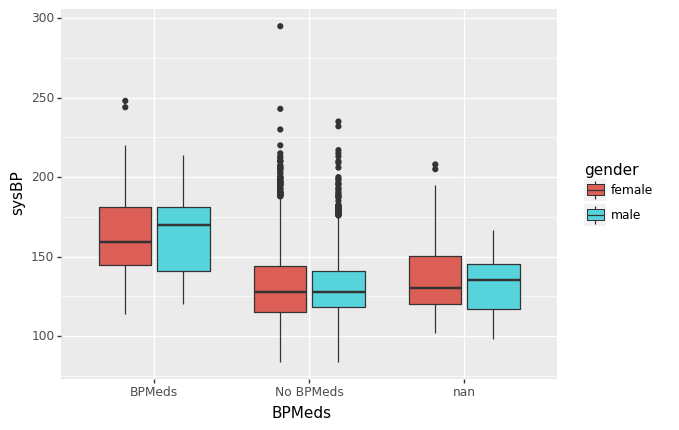

<ggplot: (-9223363250484060668)>

In [25]:
p9.ggplot(combined, p9.aes(y='sysBP', x='BPMeds', fill='gender')) + p9.geom_boxplot()

Why are there three categories of BPMeds? What does the third category imply? How does the median `sysBP` compare between the two genders in each case? What happens if you switch `fill` and `x`? Does that make it easier or harder to answer this question?

Now, repeat the above, but make a violin plot instead.

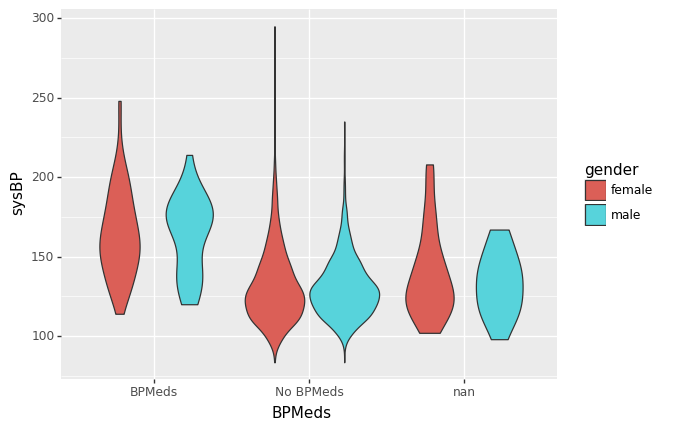

<ggplot: (8786370776177)>

In [26]:
p9.ggplot(combined, p9.aes(y='sysBP', x='BPMeds', fill='gender')) + p9.geom_violin()

Compare the violin plot with the box plot. Can you find an advantage for each type of graph?

Plot `sysBP` vs `diaBP` in a way that allows comparing the three `BPMeds` cases. How do the values of `sysBP` for those on blood pressure meds compare to those not on blood pressure meds?

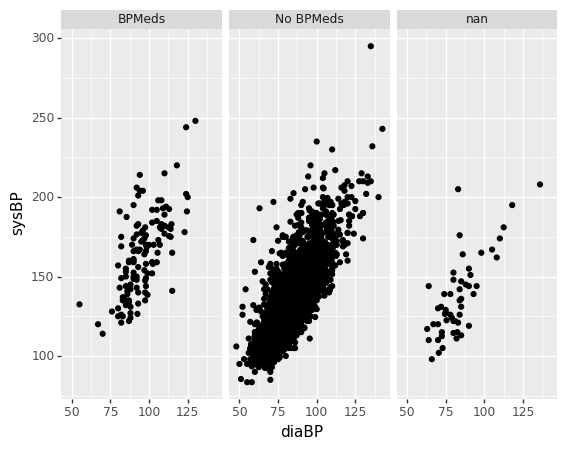

<ggplot: (8786370610580)>

In [27]:
p9.ggplot(combined, p9.aes(y='sysBP', x='diaBP')) + p9.geom_point() + p9.facet_wrap('BPMeds')

Use `p9.geom_smooth` to compare trend lines for how `sysBP` changes as `diaBP` changes by gender. Which gender shows `sysBP` values that increase faster with increasing `diaBP`?

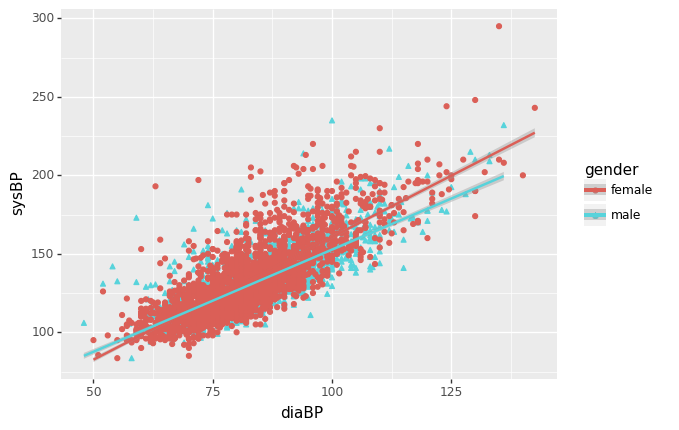

<ggplot: (-9223363250484210972)>

In [28]:
p9.ggplot(combined, p9.aes(y='sysBP', x='diaBP', color='gender', shape='gender')) + p9.geom_point() + p9.geom_smooth()

Do smokers and non-smokers show different systolic blood pressure readings? Start by making a box-plot to compare them:

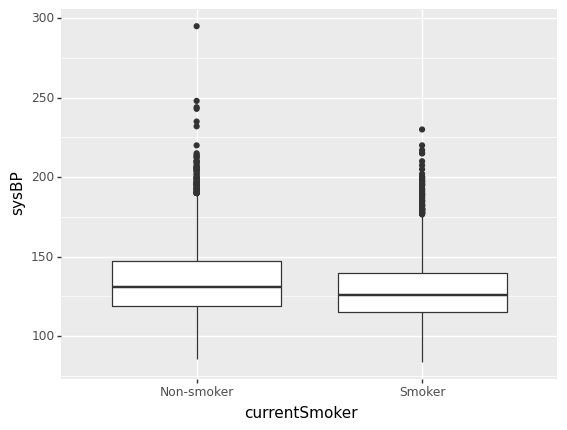

<ggplot: (-9223363250417195085)>

In [29]:
p9.ggplot(combined, p9.aes(y='sysBP', x='currentSmoker')) + p9.geom_boxplot()

Smokers have an ever-so-slightly lower median, but the ranges mostly overlap. Try subdividing this by gender.

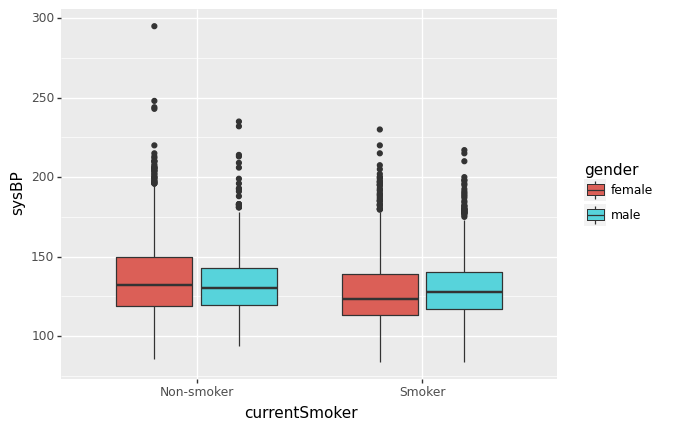

<ggplot: (-9223363250484213304)>

In [32]:
p9.ggplot(combined, p9.aes(y='sysBP', x='currentSmoker', fill='gender')) + p9.geom_boxplot()

Each case still looks pretty much the same. Can you find a condition in which male smokers are more distinct from female nonsmokers? Visualize it.

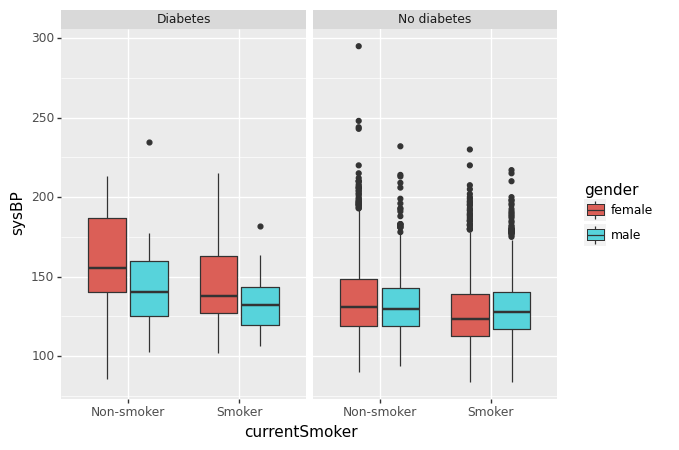

<ggplot: (8786370704546)>

In [33]:
p9.ggplot(combined, p9.aes(y='sysBP', x='currentSmoker', fill='gender')) + p9.geom_boxplot() + p9.facet_wrap('diabetes')